## Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

### Solution steps

#### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0. The state transition thus reduces to:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t) 
\end{align}$$

#### 2. Divide by leading coefficient m

We will reduce the equation to standard form by dividing through the mass coefficient.

$$\begin{align}
x''(t) + \frac{v}{m} x'(t) + \frac{a}{m} x(t) = \frac{1}{m} u(t) + \frac{1}{m}w(t) 
\end{align}$$

#### 3. Reduce to first-order differential equation

We make the following substitutions:

$$\begin{align} 
z_2(t) =&\ x'(t) \\ 
z_1(t) =&\ x(t) \, ,
\end{align}$$

which produces:

$$\begin{align}
z_2'(t) = -\frac{v}{m} z_2(t) - \frac{a}{m} z_1(t) \frac{1}{m} u(t) + \frac{1}{m}w(t)  \, .
\end{align}$$

We can re-write this into a matrix form:
$$\begin{align}
\begin{bmatrix} z_2'(t) \\ z_1'(t) \end{bmatrix} = \underbrace{\begin{bmatrix} -\frac{v}{m} & - \frac{a}{m} \\ 1 & 0 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} z_2(t) \\ z_1(t) \end{bmatrix}}_{z(t)} + \underbrace{\begin{bmatrix} \frac{1}{m} \\ 0 \end{bmatrix}}_{B} u(t) + \begin{bmatrix} \frac{1}{m} \\ 0 \end{bmatrix} w(t)  \, .
\end{align}$$


#### 4. Discretize 

We can perform an approximate discretization using Euler's method and a step size of 1:

$$\begin{align}
z_{t+1} - z_{t} =&\ A z_t + B u_t + B w_t \\
z_{t+1} =&\ (I + A) z_t + B u_t + B w_t
\end{align}$$

#### 5. Shorthand notation for coefficients

$$\begin{align} 
\theta_1 =&\ \frac{-v}{m} \\
\theta_2 =&\ \frac{-a}{m} \\
\eta =&\ \frac{1}{m} \, .
\end{align}$$

Given three equations and three unknowns, I can recover $m$, $v$ and $a$ from $\theta_1$, $\theta_2$, and $\eta$.

#### 6. Convert to Gaussian probabilities

$$\begin{align}
z_{t+1} \sim&\ \mathcal{N}(A(\theta) z_{t} + B(\eta) u_t, C(\eta) \tau) \\ 
y_t \sim&\ \mathcal{N}(c^{\top} z_t, \sigma) \, ,
\end{align}$$

for $C(\eta) = \begin{bmatrix} \frac{1}{m} & 0 \\ 0 & 0 \end{bmatrix}$, $c = \begin{bmatrix} 0 & 1 \end{bmatrix}$, $w_t \sim \mathcal{N}(0, \tau)$ and $e_t \sim \mathcal{N}(0, \sigma)$.

I will first study a situation with known measurement noise (so $\sigma$ is fixed). That means I need priors for $\theta$, $\eta$, and $\tau$. The variables are all strictly positive, which means they can be modeled by log-normal and gamma distributions:

$$\begin{align}
\log(\theta) \sim&\ \mathcal{N}(m_\theta, W_\theta) \\
\log(\eta) \sim&\ \mathcal{N}(m_\eta, W_\eta) \\
\tau \sim&\ \Gamma(a_\tau, b_\tau) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots

viz = false

false

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [5]:
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

I will use the Nonlinear node to cope with a multivariate log-normal distribution.

In [7]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV lθ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:W_θ, dims=(2,2)))
@RV lη ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Nonlinear function
g(x) = exp.(x)
g_inv(x) = log.(x) # Not used in Nonlinear due to DomainError

# Nonlinear node
@RV θ ~ Nonlinear{Unscented}(lθ; g=g, dims=(2,))
@RV η ~ Nonlinear{Unscented}(lη; g=g, dims=(1,))

# Observation selection variable
c = [1, 0]

# Measurement precision
τ_y = 1e5

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:W_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), τ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), τ_y, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 16178318215077639034 -->
 
 16178318215077639034 
 
 𝒩 
 z_t 
 
<!-- 1366318408083338550 -->
 
 1366318408083338550 
 
 placeholder_m_z 
 
<!-- 16178318215077639034--1366318408083338550 -->
 
 16178318215077639034--1366318408083338550 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16388236009824034879 -->
 
 16388236009824034879 
 
 placeholder_W_z 
 
<!-- 16178318215077639034--16388236009824034879 -->
 
 16178318215077639034--16388236009824034879 
 
 W_z 
 1 out 
 3 w 
 
<!-- 12136913149418657836 -->
 
 12136913149418657836 
 
 Nonlinear{Unscented} 
 nonlinear_2 
 
<!-- 8863087970899275539 -->
 
 8863087970899275539 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12136913149418657836--8863087970899275539 -->
 
 12136913149418657836--8863087970899275539 
 
 lη 
 1 out 
 2 in1 
 
<!-- 11222308954724538823 -->
 
 11222308954724538823 
 
 ARC 
 x_t 
 
<!-- 11222308954724538823--16178318215077639034 -->
 
 11222308954724538823--16178318215077639034 
 
 z_t 
 1 out 
 2 x 
 
<!-- 11222308954724538823--12136913149418657836 -->
 
 11222308954724538823--12136913149418657836 
 
 η 
 1 out 
 4 η 
 
<!-- 1063529776284465846 -->
 
 1063529776284465846 
 
 placeholder_u_t 
 
<!-- 11222308954724538823--1063529776284465846 -->
 
 11222308954724538823--1063529776284465846 
 
 u_t 
 1 out 
 5 u 
 
<!-- 18132301364831423457 -->
 
 18132301364831423457 
 
 Nonlinear{Unscented} 
 nonlinear_1 
 
<!-- 11222308954724538823--18132301364831423457 -->
 
 11222308954724538823--18132301364831423457 
 
 θ 
 1 out 
 3 θ 
 
<!-- 7715435379138396956 -->
 
 7715435379138396956 
 
 Gam 
 gamma_1 
 
<!-- 11222308954724538823--7715435379138396956 -->
 
 11222308954724538823--7715435379138396956 
 
 τ 
 1 out 
 6 γ 
 
<!-- 11738211255751956531 -->
 
 11738211255751956531 
 
 clamp_2 
 
<!-- 17777645011502703447 -->
 
 17777645011502703447 
 
 clamp_1 
 
<!-- 15473522550066512136 -->
 
 15473522550066512136 
 
 placeholder_w_η 
 
<!-- 5140390983322944747 -->
 
 5140390983322944747 
 
 dot 
 dotproduct_1 
 
<!-- 5140390983322944747--11222308954724538823 -->
 
 5140390983322944747--11222308954724538823 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 5140390983322944747--17777645011502703447 -->
 
 5140390983322944747--17777645011502703447 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 7635231510672297898 -->
 
 7635231510672297898 
 
 placeholder_y_t 
 
<!-- 12086718837201908828 -->
 
 12086718837201908828 
 
 𝒩 
 y_t 
 
<!-- 7635231510672297898--12086718837201908828 -->
 
 7635231510672297898--12086718837201908828 
 
 y_t 
 1 out 
 1 out 
 
<!-- 3112798360371997037 -->
 
 3112798360371997037 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 18132301364831423457--3112798360371997037 -->
 
 18132301364831423457--3112798360371997037 
 
 lθ 
 1 out 
 2 in1 
 
<!-- 12086718837201908828--11738211255751956531 -->
 
 12086718837201908828--11738211255751956531 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 12086718837201908828--5140390983322944747 -->
 
 12086718837201908828--5140390983322944747 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 10665143616554382521 -->
 
 10665143616554382521 
 
 placeholder_b_τ 
 
<!-- 1558253787911722478 -->
 
 1558253787911722478 
 
 placeholder_m_η 
 
<!-- 6613078857666186690 -->
 
 6613078857666186690 
 
 placeholder_W_θ 
 
<!-- 3112798360371997037--6613078857666186690 -->
 
 3112798360371997037--6613078857666186690 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 6835615956785487534 -->
 
 6835615956785487534 
 
 placeholder_m_θ 
 
<!-- 3112798360371997037--6835615956785487534 -->
 
 3112798360371997037--6835615956785487534 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 7715435379138396956--10665143616554382521 -->
 
 7715435379138396956--10665143616554382521 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 6732334858839221545 -->
 
 6732334858839221545 
 
 placeholder_a_τ 
 
<!-- 7715435379138396956--6732334858839221545 -

In [8]:
# Infer an algorithm
q = PosteriorFactorization(z_t, x_t, θ, lθ, η, lη, τ, ids=[:z, :x, :θ, :lθ, :η, :lη, :τ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

In [9]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (zeros(1,T+1), 0.1 *ones(1,T+1))
params_τ = (0.1*ones(1,T+1), 0.01*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:lθ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:lη] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0., 0.], w=[1. 0.; 0. 1.])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=0., w=1.)
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,t], b=params_τ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :m_θ => params_θ[1][:,t],
                :m_η => params_η[1][1,t],
                :W_z => params_x[2][:,:,t],
                :W_θ => params_θ[2][:,:,t],
                :w_η => params_η[2][1,t],
                :a_τ => params_τ[1][1,t],
                :b_τ => params_τ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepτ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_θ[1][:,t+1] = unsafeMean(marginals[:lθ])
    params_η[1][1,t+1] = unsafeMean(marginals[:lη])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[2][:,:,t+1] = marginals[:lθ].params[:w]
    params_η[2][1,t+1] = marginals[:lη].params[:w]
    params_τ[1][1,t+1] = marginals[:τ].params[:a]
    params_τ[2][1,t+1] = marginals[:τ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:03:34:56m


### Visualize results

In [10]:
viz = true

true

In [11]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/estimated_states01.png")
end

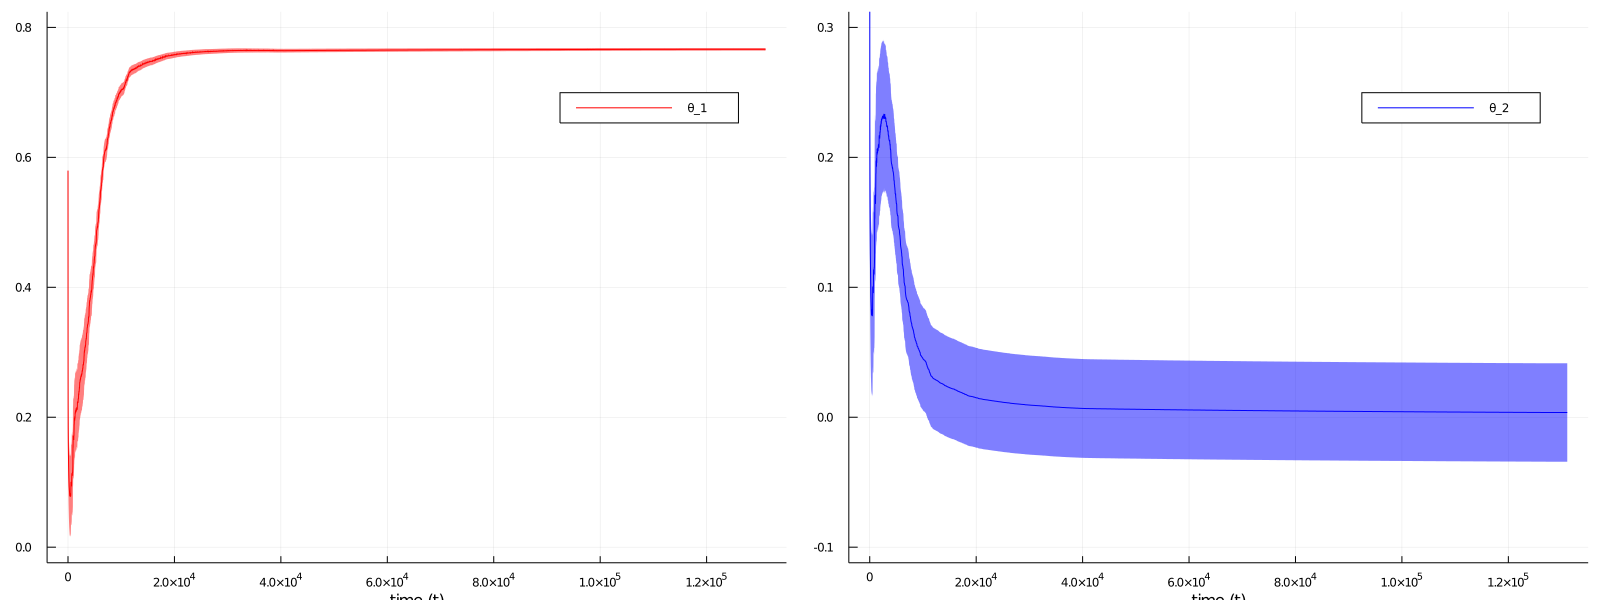

In [37]:
# Extract mean of coefficient marginals
estimated_coeffs_1_mean = exp.(params_θ[1][1,2:end])
estimated_coeffs_1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_coeffs_2_mean = exp.(params_θ[1][2,2:end])
estimated_coeffs_2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))

if viz
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)", ylim=[0., 0.8])
    p2b = Plots.plot(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2", xlabel="time (t)", ylim=[-0.1, 0.3])
    p2 = plot(p2a, p2b, size=(1600,600))
#     Plots.savefig(p2, "viz/estimated_coeffs.png")
end

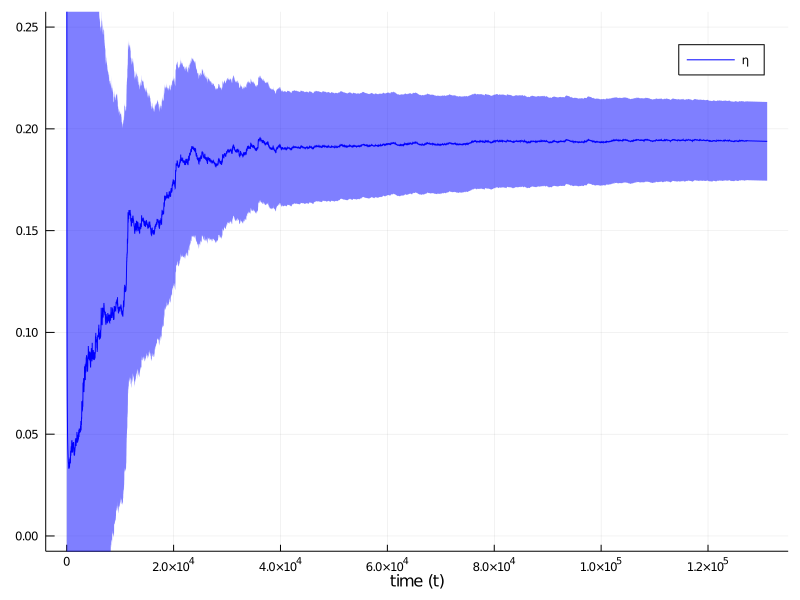

In [38]:
# Extract mean of control coefficient marginals
estimated_ccoeff_mean = exp.(params_η[1][1,2:end])
estimated_ccoeff_std = sqrt.(inv.(params_η[2][1,2:end]))

if viz
    # Plot both coefficients next to each other
    p3 = Plots.plot(1:n:T, estimated_ccoeff_mean[1:n:T], ribbon=[estimated_ccoeff_std[1:n:T], estimated_ccoeff_std[1:n:T]], color="blue", label="η", xlabel="time (t)", size=(800,600), ylim=[0.0, 0.25])
#     Plots.savefig(p3, "viz/estimated_ccoeff.png")
end

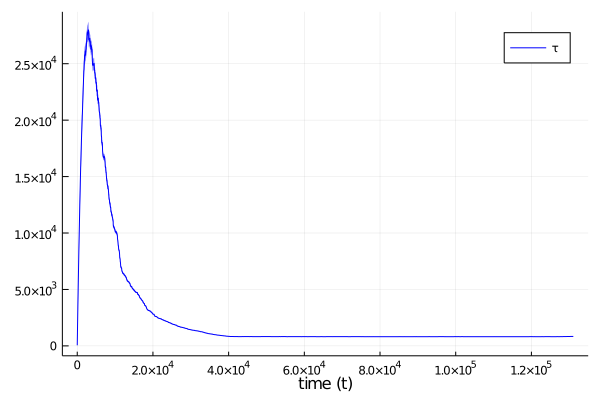

In [39]:
# Extract mean of process precision marginals
estimated_pnoise_mean = params_τ[1][1,2:end] ./ params_τ[2][1,2:end]
estimated_pnoise_std = sqrt.(params_τ[1][1,2:end] ./ params_τ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T, estimated_pnoise_mean[1:n:T], ribbon=[estimated_pnoise_std[1:n:T], estimated_pnoise_std[1:n:T]],color="blue", label="τ", xlabel="time (t)")
#     Plots.savefig(p4, "viz/estimated_pnoise.png")
end

## Solving nonlinear system of equations

We currently have estimates for $\theta_1$, $\theta_2$, and $\eta$. But we want to know the original coefficients, $\mu$, $\nu$ and $\kappa$, which actually have a physical meaning. To obtain estimates for those, we first have to solve the following nonlinear system of equations:

$$\begin{align} 
\hat{\theta_1} =&\ \frac{2(1 + \zeta \omega_0)}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\hat{\theta_2} =&\ \frac{1}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\hat{\eta} =&\ \frac{1}{\mu(1 + 2 \zeta \omega_0 + \omega_0^2)}
\end{align}$$

--> Implementation using NLsolve.jl

In [29]:
using NLsolve

In [30]:
# Current estimates of parameters
global estimates = [estimated_coeffs_1_mean[1,end], estimated_coeffs_2_mean[2,end], estimated_ccoeff_mean[1,end]]

3-element Array{Float64,1}:
 0.5795832849475638
 0.5376816165519849
 0.9317208394054709

In [31]:
# Define nonlinear system of equations
function f1!(F, x)
    F[1] = (2*(1 + x[1]*x[2]))/(1 + 2*x[1]*x[2] + x[2]^2)  - estimates[1]
    F[2] = 1/(1 + 2*x[1]*x[2] + x[2]^2) - estimates[2]
    F[3] = 1/(x[3]*(1 + 2*x[1]*x[2] + x[2]^2)) - estimates[3]
end

# Jacobian of each equation
function j1!(J, x)
    
    # F[1]
    J[1, 1] = (2*x[2]*(1 + 2*x[1]*x[2] + x[2]^2) - 2*(1 + x[1]*x[2])*2*x[2]) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[1, 2] = (2*x[1]*(1 + 2*x[1]*x[2] + x[2]^2) - 2*(1 + x[1]*x[2])*(2*x[1] + 2*x[2])) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[1, 3] = 0.
    
    # F[2]
    J[2, 1] = (-2*x[2]) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[2, 2] = (-(2*x[1] + 2*x[2])) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[2, 3] = 0.
    
    # F[3]
    J[3, 1] = (-2*x[3]*x[2]) / (x[3]*(1 + 2*x[1]*x[2] + x[2]^2))^2
    J[3, 2] = (-(2*x[3]*x[2] + 2*x[3]*x[2])) / (x[3]*(1 + 2*x[1]*x[2] + x[2]^2))^2
    J[3, 3] = (-(1 + 2*x[1]*x[2] + x[2]^2)) / (x[3]*(1 + 2*x[1]*x[2] + x[2]^2))^2
    
end

# Call solver
# x_solved = nlsolve(f1!, j1!, [1. 1. 1.])
x_solved = nlsolve(f1!, [1. 1. 1.], autodiff=:forward)

# Extract new estimates
global ζ, ω0, μ = x_solved.zero

1×3 Array{Float64,2}:
 -0.345375  1.33488  0.577084

We now have estimates for $\zeta$, $\omega_0$ and $\mu$. But we still need the friction $\nu$ and spring $\kappa$ coefficients. These can be obtained by solving another nonlinear system of equations:

$$\begin{align} 
\zeta =&\ \frac{\nu}{2\sqrt{\mu \kappa}} \\ 
\omega_0 =&\ \sqrt{\frac{\kappa}{\mu}} \, .
\end{align}$$

In [32]:
# Define nonlinear system of equations
function f2!(F, x)
    F[1] = x[1] / (2*sqrt(μ * x[2])) - ζ
    F[2] = sqrt(x[2] / μ) - ω0
end

# Jacobian of each equation
function j2!(J, x)
    
    # F[1]
    J[1, 1] = 1 / (2*sqrt(μ*x[2]))
    J[1, 2] = (-x[1]*μ) / (4*(μ*x[2])^(3/2))
    
    # F[2]
    J[2, 1] = 0.
    J[2, 2] = (sqrt(x[2]/μ)) / (2*x[2])
    
end

# Call solver
# x_solved = nlsolve(f2!, j2!, [1. 1.])
x_solved = nlsolve(f2!, [1. 1.], autodiff=:forward)

# Extract new estimates
global ν, κ = x_solved.zero

1×2 Array{Float64,2}:
 -0.532112  1.02831

So, in total we estimate the dynamical parameters as follows:

In [33]:
println("μ = " *string(μ))
println("ν = " *string(ν))
println("κ = " *string(κ))

μ = 0.5770844587778071
ν = -0.5321121217060165
κ = 1.0283105092108045
